<a href="https://colab.research.google.com/github/jaydeepthik/Siamese-face-verification/blob/master/siamese_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')


In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model, Sequential
from keras import layers
from keras import optimizers
import keras.backend as K
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
data_path = "/content/drive/My Drive/Colab Notebooks/lfw_dataset/orl_faces"


In [4]:
img = Image.open(data_path+"/s1/1.pgm")
img1 = img.convert('L')
img1 = img_to_array(img1)
img2 = img_to_array(img)
#img = img.reshape((112,92))
#print(img.shape)
#plt.imshow(img1[:,:,0], cmap='gray')
#print(img1[0][0])
print((img1-img2).sum())
print(img1.dtype)

0.0
float32


In [0]:
size = 2
n_samples = 20000
def process_data(size, n_samples):
  
  img = img_to_array(Image.open(data_path+"/s1/1.pgm"))
  img = img[::size,::size]
  
  h_dim = img.shape[0]
  w_dim = img.shape[1]
  
  count = 0
  
  X_a_p = np.zeros((n_samples,2,h_dim, w_dim, 1))
  y_a_p = np.ones((n_samples, 1))
  
  for i in range(40):
    print(i, sep='')
    for j in range(int(n_samples/40)):
      index1 = 0
      index2 = 0
      
      while index1 == index2:
        index1 = np.random.randint(10)
        index2 = np.random.randint(10)
        
      X_a = img_to_array(Image.open(data_path+"/s"+str(i+1)+"/"+str(index1+1)+".pgm"))
      #X_a = X_a[:,:,0]
      X_a =X_a[::size, ::size ]
      
      X_p = img_to_array(Image.open(data_path+"/s"+str(i+1)+"/"+str(index2+1)+".pgm"))
      #X_p = X_p[:,:,0]
      X_p =X_p[::size, ::size]
      
      X_a_p[count,0,:,:] = X_a
      X_a_p[count,1,:,:] = X_p
      
      count+=1
  
  count = 0
  
  X_a_n = np.zeros((n_samples,2,h_dim, w_dim, 1))
  y_a_n = np.zeros((n_samples, 1))
    
  
  for i in range(int(n_samples/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = img_to_array(Image.open(data_path+'/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm'))
            img2 = img_to_array(Image.open(data_path+'/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm'))

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            X_a_n[count, 0, :, :] = img1
            X_a_n[count, 1, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_a_n[count] = 0
            count += 1
  
  X = np.concatenate([X_a_p, X_a_n], axis=0)/255
  y = np.concatenate([y_a_p, y_a_n], axis=0)
  return X, y
  

In [0]:
X, y = process_data(size, n_samples)

In [0]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.25,shuffle=True)
#X_train = X_train.reshape((X_train.shape[0],X_train.shape[1], X_train.shape[2], X_train.shape[3], 1))

In [8]:
(y_test==0.).sum() + (y_train==0.).sum()

20000

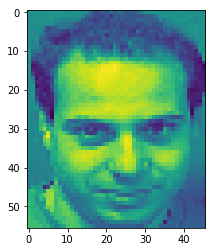

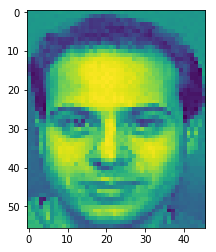

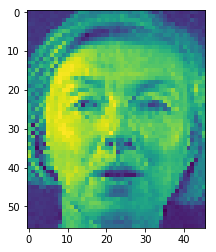

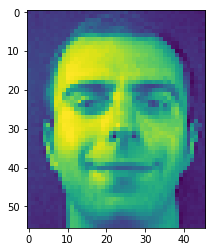

array([[1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.]])

In [9]:
id=5004
plt.imshow(X_train[id,0,:,:,0])
plt.show()
plt.imshow(X_train[id,1,:,:,0])
plt.show()
plt.imshow(X_train[id+1,0,:,:,0])
plt.show()
plt.imshow(X_train[id+1,1,:,:,0])
plt.show()
#print(X_train[0])
y_train[id:id+10]

In [10]:
print(X.shape, y.shape)

(40000, 2, 56, 46, 1) (40000, 1)


In [0]:
def base_model(input_shape):
  
  model = Sequential()
  model.add(layers.Conv2D(32, 3, input_shape=input_shape, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPool2D())
  
  model.add(layers.Conv2D(64, 3))
  model.add(layers.Activation('relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D())
  
  model.add(layers.Conv2D(128, 3))
  model.add(layers.Activation('relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D())
  
  model.add(layers.Flatten())
  model.add(layers.Dense(256))
  model.add(layers.Dropout(0.25))
  model.add(layers.Dense(128))
  
  
  
  return model

In [31]:
input_shape = X_train.shape[2:]
print(input_shape)
image_a = layers.Input(shape = input_shape)
image_b = layers.Input(shape = input_shape)

base_net = base_model(input_shape)
emb_a = base_net(image_a)
emb_b = base_net(image_b)

(56, 46, 1)


In [0]:
def euc_distance(vectors):
  v_a, v_y = vectors
  return K.sqrt(K.sum(K.square(v_a - v_y), axis=1, keepdims=True))

def euc_op_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)


distance = layers.Lambda(euc_distance, output_shape=euc_op_shape)([emb_a, emb_b])

In [0]:
model = Model([image_a, image_b], distance)

In [35]:
def loss_contrastive(y_true, y_pred):
  alpha = 1
  return K.mean(y_true*K.square(y_pred) + (1 - y_true) * K.square(K.maximum(alpha - y_pred, 0)))

model.compile(optimizer=optimizers.Adam(0.001), loss = loss_contrastive)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 56, 46, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 56, 46, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          782080      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]               
          

In [37]:
inp_1 = X_train[:,0]
inp_2 = X_train[:,1]
model.fit([inp_1, inp_2], y_train,validation_split=0.2, batch_size=128, epochs=30)

#inp_1.shape

Train on 24000 samples, validate on 6000 samples
Epoch 1/30
24000/24000 [==============================] - 7s 285us/step - loss: 0.0206 - val_loss: 0.0084
Epoch 2/30
24000/24000 [==============================] - 7s 280us/step - loss: 0.0197 - val_loss: 0.0091
Epoch 3/30
24000/24000 [==============================] - 7s 279us/step - loss: 0.0196 - val_loss: 0.0077
Epoch 4/30
24000/24000 [==============================] - 7s 281us/step - loss: 0.0200 - val_loss: 0.0077
Epoch 5/30
24000/24000 [==============================] - 7s 283us/step - loss: 0.0194 - val_loss: 0.0081
Epoch 6/30
24000/24000 [==============================] - 7s 282us/step - loss: 0.0199 - val_loss: 0.0079
Epoch 7/30
24000/24000 [==============================] - 7s 286us/step - loss: 0.0195 - val_loss: 0.0096
Epoch 8/30
24000/24000 [==============================] - 7s 287us/step - loss: 0.0190 - val_loss: 0.0071
Epoch 9/30
24000/24000 [==============================] - 7s 280us/step - loss: 0.0181 - val_loss: 0.00

different
[[2.022332]]


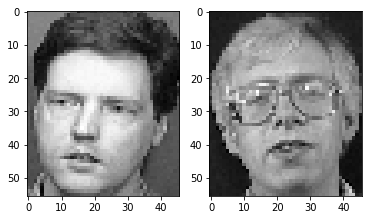

In [94]:
index = 2550
tr_value = 0.7
pred = model.predict([np.expand_dims(X_test[index,0], axis=0), np.expand_dims(X_test[index,1], axis=0)])
if pred[0]>= tr_value:
  print("different")
else:
  print("same")
print(pred)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(X_test[index,0,:,:,0], cmap='gray')
axarr[1].imshow(X_test[index,1,:,:,0], cmap='gray')
plt.show()

In [0]:
#new_model = Model(model.input[0], [model.get_output_at(0)])
base_net.predict([np.expand_dims(X_test[index,0], axis=0)]).shape

In [0]:
K.clear_session()
import tensorflow as tf
tf.reset_default_graph()